# Treinamento de Modelos Preditivos com Divisão por Sensibilidade CID-10

Este notebook realiza o treinamento de modelos preditivos para previsão de óbitos por doenças respiratórias, utilizando a segmentação por sensibilidade com base nos códigos CID-10 (Alta, Média, Baixa Sensibilidade) e a base completa com clusters. Essa divisão visa melhorar a performance dos modelos e permitir interpretações mais específicas sobre o impacto dos fatores ambientais em diferentes tipos de doenças.

Foi escolhido dividir a base em 70% para treinamento e 30% para teste utilizando uma separação aleatória. Essa estratégia permite uma amostragem representativa dos dados ao longo do tempo, mantendo a proporção original das variáveis e evitando possíveis vieses temporais. Além disso, observou-se que essa divisão proporcionou melhor desempenho dos modelos em comparação com a separação por ano, o que justifica sua adoção neste contexto."


In [415]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [416]:
# Dicionário para guardar resultados
resultados = {
    "Modelo": [],
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "R2": []
}

# Função de avaliação
def avaliar_modelo(nome, modelo, X_train, X_test, y_train, y_test):
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"== {nome} ==")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print()

    resultados["Modelo"].append(nome)
    resultados["MAE"].append(mae)
    resultados["MSE"].append(mse)
    resultados["RMSE"].append(rmse)
    resultados["R2"].append(r2)




In [417]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [418]:
def identificar_estacao(mes):
    if mes in [12, 1, 2]:
        return "verao"
    elif mes in [3, 4, 5]:
        return "outono"
    elif mes in [6, 7, 8]:
        return "inverno"
    else:
        return "primavera"

In [419]:
mapa_qualidade = {
    "Boa": 1,
    "Moderada": 2,
    "Ruim": 3,
    "Muito Ruim": 4,
    "Péssima": 5
}

## Treinamento - Alta Sensibilidade

In [420]:

df = pd.read_csv("/Users/mariaisabel/Documents/PUC/5°Periodo/Projeto CD/ENG4040/Divisao/planilha_alta.csv")

# ======= 1. Conversão de colunas numéricas ============
numericas = ["OBITOS", "AREA_DESMATADA_KM2", "FRP", "RISCOFOGO", "PRECIPITACAO", "DIASEMCHUVA", "pm2.5_atm"]
df[numericas] = df[numericas].apply(pd.to_numeric, errors="coerce")


df["estacao"] = df["mes"].apply(identificar_estacao)

df["qualidade_ar_ordinal"] = df["QUALIDADE_AR_CLASSIFICADA"].map(mapa_qualidade)

df["ano_mes"] = df["ano"].astype(str) + "-" + df["mes"].astype(str).str.zfill(2)

df["log_OBITOS"] = np.log1p(df["OBITOS"])  # log(1 + OBITOS)


df = pd.get_dummies(df, columns=["Categoria CID-10", "estacao"], drop_first=True)

features = [
    "AREA_DESMATADA_KM2", "FRP", "RISCOFOGO", "PRECIPITACAO",
    "DIASEMCHUVA", "pm2.5_atm", "qualidade_ar_ordinal"
] + [col for col in df.columns if col.startswith("Categoria CID-10_") or col.startswith("estacao_")]

X = df[features]
y = df["log_OBITOS"] # ou use df["log_OBITOS"] para teste com transformação logarítmica

# ======= 8. Tratamento final de NaN ===============
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# Separar em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


print(f"Tamanho total da base: {len(df)}")
print(f"Amostras para treino (2020–2022): {len(X_train)} ({len(X_train)/len(df)*100:.2f}%)")
print(f"Amostras para teste (2023): {len(X_test)} ({len(X_test)/len(df)*100:.2f}%)")


Tamanho total da base: 396
Amostras para treino (2020–2022): 277 (69.95%)
Amostras para teste (2023): 119 (30.05%)


In [421]:

lr = LinearRegression()
avaliar_modelo("Regressão Linear", lr, X_train, X_test, y_train, y_test)

tree = DecisionTreeRegressor(random_state=42)
avaliar_modelo("Árvore de Regressão", tree, X_train, X_test, y_train, y_test)

xgb = XGBRegressor(n_estimators=100, random_state=42)
avaliar_modelo("XGBoost", xgb , X_train, X_test, y_train, y_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
avaliar_modelo("Random Forest", rf, X_train, X_test, y_train, y_test)



== Regressão Linear ==
MAE: 0.2491
MSE: 0.1045
RMSE: 0.3233
R²: 0.3348

== Árvore de Regressão ==
MAE: 0.2878
MSE: 0.2002
RMSE: 0.4474
R²: -0.2743

== XGBoost ==
MAE: 0.2992
MSE: 0.1650
RMSE: 0.4062
R²: -0.0504

== Random Forest ==
MAE: 0.2732
MSE: 0.1292
RMSE: 0.3594
R²: 0.1778



/var/folders/21/vd2qtz_j303cdkf9ngj78hxw0000gn/T/ipykernel_8994/2238350280.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_resultados_alta.melt(id_vars="Modelo"), x="Modelo", y="value", hue="variable", ci=None)


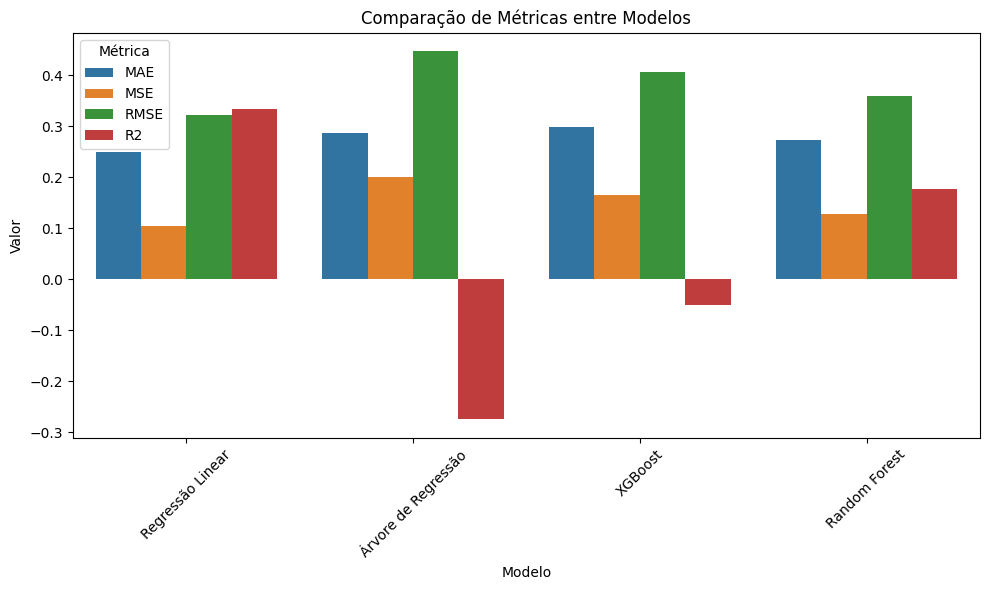

In [422]:
df_resultados_alta = pd.DataFrame(resultados)

# Comparação dos modelos com gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_resultados_alta.melt(id_vars="Modelo"), x="Modelo", y="value", hue="variable", ci=None)
plt.title("Comparação de Métricas entre Modelos")
plt.ylabel("Valor")
plt.xlabel("Modelo")
plt.legend(title="Métrica")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Treinamento - Média Sensibilidade

In [423]:

df = pd.read_csv("/Users/mariaisabel/Documents/PUC/5°Periodo/Projeto CD/ENG4040/Divisao/planilha_media.csv")

# ======= 2. Conversão de colunas numéricas ============
numericas = ["OBITOS", "AREA_DESMATADA_KM2", "FRP", "RISCOFOGO", "PRECIPITACAO", "DIASEMCHUVA", "pm2.5_atm"]
df[numericas] = df[numericas].apply(pd.to_numeric, errors="coerce")

# ======= 3. Colunas derivadas ============
df["estacao"] = df["mes"].apply(identificar_estacao)
df["qualidade_ar_ordinal"] = df["QUALIDADE_AR_CLASSIFICADA"].map(mapa_qualidade)
df["ano_mes"] = df["ano"].astype(str) + "-" + df["mes"].astype(str).str.zfill(2)
df["log_OBITOS"] = np.log1p(df["OBITOS"])  # log(1 + OBITOS)

# ======= 4. One-hot encoding para colunas categóricas ============
df = pd.get_dummies(df, columns=["Categoria CID-10", "estacao"], drop_first=True)

# ======= 5. Seleção de features ============
features = [
    "AREA_DESMATADA_KM2", "FRP", "RISCOFOGO", "PRECIPITACAO",
    "DIASEMCHUVA", "pm2.5_atm", "qualidade_ar_ordinal"
] + [col for col in df.columns if col.startswith("Categoria CID-10_") or col.startswith("estacao_")]

X = df[features]
y = df["log_OBITOS"]  # ou use df["OBITOS"] se quiser comparar

# ======= 6. Tratamento de valores faltantes ============
X = X.fillna(X.mean())
y = y.fillna(y.mean())

# ======= 7. Separar treino e teste ============
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


print(f"Tamanho total da base: {len(df)}")
print(f"Amostras para treino (2020–2022): {len(X_train)} ({len(X_train)/len(df)*100:.2f}%)")
print(f"Amostras para teste (2023): {len(X_test)} ({len(X_test)/len(df)*100:.2f}%)")


Tamanho total da base: 308
Amostras para treino (2020–2022): 215 (69.81%)
Amostras para teste (2023): 93 (30.19%)


In [424]:

lr = LinearRegression()
avaliar_modelo("Regressão Linear", lr, X_train, X_test, y_train, y_test)

tree = DecisionTreeRegressor(random_state=42)
avaliar_modelo("Árvore de Regressão", tree, X_train, X_test, y_train, y_test)

xgb = XGBRegressor(n_estimators=100, random_state=42)
avaliar_modelo("XGBoost", xgb , X_train, X_test, y_train, y_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
avaliar_modelo("Random Forest", rf, X_train, X_test, y_train, y_test)



== Regressão Linear ==
MAE: 0.4379
MSE: 0.3181
RMSE: 0.5640
R²: 0.5322

== Árvore de Regressão ==
MAE: 0.4967
MSE: 0.4830
RMSE: 0.6950
R²: 0.2898

== XGBoost ==
MAE: 0.3956
MSE: 0.3004
RMSE: 0.5481
R²: 0.5582

== Random Forest ==
MAE: 0.3847
MSE: 0.2612
RMSE: 0.5111
R²: 0.6159



/var/folders/21/vd2qtz_j303cdkf9ngj78hxw0000gn/T/ipykernel_8994/2059046997.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_resultados_media.melt(id_vars="Modelo"), x="Modelo", y="value", hue="variable", ci=None)


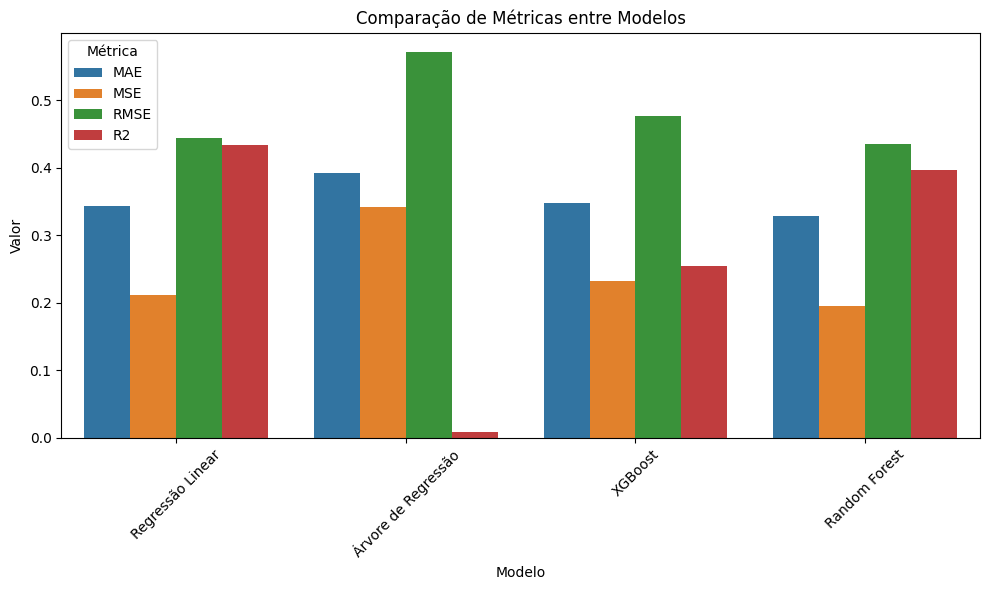

In [425]:
df_resultados_media = pd.DataFrame(resultados)

# Comparação dos modelos com gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_resultados_media.melt(id_vars="Modelo"), x="Modelo", y="value", hue="variable", ci=None)
plt.title("Comparação de Métricas entre Modelos")
plt.ylabel("Valor")
plt.xlabel("Modelo")
plt.legend(title="Métrica")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Treinamento - Baixa Sensibilidade

In [426]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# === Funções auxiliares ===
def identificar_estacao(mes):
    if mes in [12, 1, 2]:
        return "verao"
    elif mes in [3, 4, 5]:
        return "outono"
    elif mes in [6, 7, 8]:
        return "inverno"
    else:
        return "primavera"

mapa_qualidade = {
    "Boa": 1,
    "Moderada": 2,
    "Ruim": 3,
    "Muito Ruim": 4,
    "Péssima": 5
}

# === 1. Carregamento ===
df = pd.read_csv("/Users/mariaisabel/Documents/PUC/5°Periodo/Projeto CD/ENG4040/Divisao/planilha_baixa.csv")

# === 2. Conversão de colunas numéricas ===
numericas = ["OBITOS", "AREA_DESMATADA_KM2", "FRP", "RISCOFOGO", "PRECIPITACAO", "DIASEMCHUVA", "pm2.5_atm"]
df[numericas] = df[numericas].apply(pd.to_numeric, errors="coerce")

# === 3. Colunas derivadas ===
df["estacao"] = df["mes"].apply(identificar_estacao)
df["qualidade_ar_ordinal"] = df["QUALIDADE_AR_CLASSIFICADA"].map(mapa_qualidade)
df["ano_mes"] = df["ano"].astype(str) + "-" + df["mes"].astype(str).str.zfill(2)
df["log_OBITOS"] = np.log1p(df["OBITOS"])  # log(1 + OBITOS)

# === 4. One-hot encoding ===
df = pd.get_dummies(df, columns=["Categoria CID-10", "estacao"], drop_first=True)

# === 5. Seleção de features ===
features = [
    "AREA_DESMATADA_KM2", "FRP", "RISCOFOGO", "PRECIPITACAO",
    "DIASEMCHUVA", "pm2.5_atm", "qualidade_ar_ordinal"
] + [col for col in df.columns if col.startswith("Categoria CID-10_") or col.startswith("estacao_")]

X = df[features]
y = df["log_OBITOS"]

# === 6. Tratamento de NaNs ===
X = X.fillna(X.mean())
y = y.fillna(y.mean())


# === 7. Separar treino e teste ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Tamanho total da base: {len(df)}")
print(f"Amostras para treino (2020–2022): {len(X_train)} ({len(X_train)/len(df)*100:.2f}%)")
print(f"Amostras para teste (2023): {len(X_test)} ({len(X_test)/len(df)*100:.2f}%)")


Tamanho total da base: 627
Amostras para treino (2020–2022): 438 (69.86%)
Amostras para teste (2023): 189 (30.14%)


In [427]:

lr = LinearRegression()
avaliar_modelo("Regressão Linear", lr, X_train, X_test, y_train, y_test)

tree = DecisionTreeRegressor(random_state=42)
avaliar_modelo("Árvore de Regressão", tree, X_train, X_test, y_train, y_test)

xgb = XGBRegressor(n_estimators=100, random_state=42)
avaliar_modelo("XGBoost", xgb , X_train, X_test, y_train, y_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
avaliar_modelo("Random Forest", rf, X_train, X_test, y_train, y_test)



== Regressão Linear ==
MAE: 0.1850
MSE: 0.0797
RMSE: 0.2824
R²: 0.2717

== Árvore de Regressão ==
MAE: 0.2591
MSE: 0.2459
RMSE: 0.4958
R²: -1.2454

== XGBoost ==
MAE: 0.2408
MSE: 0.1566
RMSE: 0.3958
R²: -0.4305

== Random Forest ==
MAE: 0.2103
MSE: 0.1202
RMSE: 0.3467
R²: -0.0980



/var/folders/21/vd2qtz_j303cdkf9ngj78hxw0000gn/T/ipykernel_8994/3042056819.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_resultados_baixa.melt(id_vars="Modelo"), x="Modelo", y="value", hue="variable", ci=None)


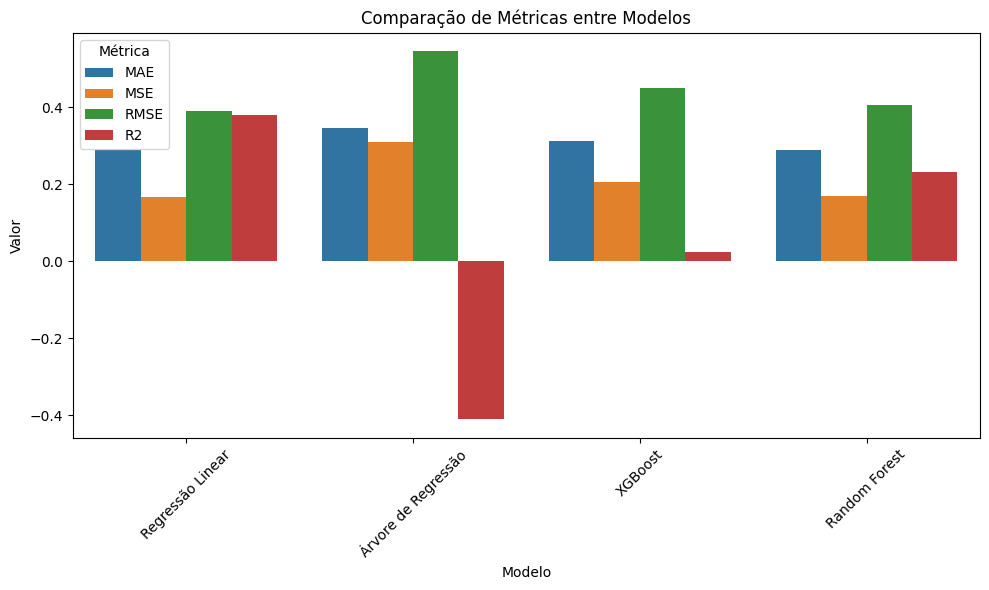

In [428]:
df_resultados_baixa = pd.DataFrame(resultados)

# Comparação dos modelos com gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_resultados_baixa.melt(id_vars="Modelo"), x="Modelo", y="value", hue="variable", ci=None)
plt.title("Comparação de Métricas entre Modelos")
plt.ylabel("Valor")
plt.xlabel("Modelo")
plt.legend(title="Métrica")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Treinamento - Base Unificada com Cluster

In [429]:
import pandas as pd
import numpy as np

# 1. Carregar os dados
df = pd.read_csv("/Users/mariaisabel/Documents/PUC/5°Periodo/Projeto CD/ENG4040/Clustering/planilha/planilha_unificada_clusterizado.csv")

# 2. Conversão de colunas numéricas
numericas = ["OBITOS", "AREA_DESMATADA_KM2", "FRP", "RISCOFOGO", "PRECIPITACAO", "DIASEMCHUVA", "pm2.5_atm"]
df[numericas] = df[numericas].apply(pd.to_numeric, errors="coerce")

# 3. Colunas derivadas
df["estacao"] = df["mes"].apply(identificar_estacao)
df["qualidade_ar_ordinal"] = df["QUALIDADE_AR_CLASSIFICADA"].map(mapa_qualidade)
df["ano_mes"] = df["ano"].astype(str) + "-" + df["mes"].astype(str).str.zfill(2)
df["log_OBITOS"] = np.log1p(df["OBITOS"])  # log(1 + OBITOS)

# 4. One-hot encoding
df = pd.get_dummies(df, columns=["Categoria CID-10", "estacao"], drop_first=True)

# 5. Seleção de features
features = [
    "AREA_DESMATADA_KM2", "FRP", "RISCOFOGO", "PRECIPITACAO",
    "DIASEMCHUVA", "pm2.5_atm", "qualidade_ar_ordinal"
] + [col for col in df.columns if col.startswith("Categoria CID-10_") or col.startswith("estacao_")]

X = df[features]
y = df["log_OBITOS"]

# 6. Tratamento de NaNs
X = X.fillna(X.mean())
y = y.fillna(y.mean())


In [430]:
# Separar treino e teste ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Tamanho total da base: {len(df)}")
print(f"Amostras para treino (2020–2022): {len(X_train)} ({len(X_train)/len(df)*100:.2f}%)")
print(f"Amostras para teste (2023): {len(X_test)} ({len(X_test)/len(df)*100:.2f}%)")

Tamanho total da base: 399
Amostras para treino (2020–2022): 279 (69.92%)
Amostras para teste (2023): 120 (30.08%)


In [431]:

lr = LinearRegression()
avaliar_modelo("Regressão Linear", lr, X_train, X_test, y_train, y_test)

tree = DecisionTreeRegressor(random_state=42)
avaliar_modelo("Árvore de Regressão", tree, X_train, X_test, y_train, y_test)

xgb = XGBRegressor(n_estimators=100, random_state=42)
avaliar_modelo("XGBoost", xgb , X_train, X_test, y_train, y_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
avaliar_modelo("Random Forest", rf, X_train, X_test, y_train, y_test)



== Regressão Linear ==
MAE: 0.3480
MSE: 0.2316
RMSE: 0.4812
R²: 0.7171

== Árvore de Regressão ==
MAE: 0.4139
MSE: 0.4604
RMSE: 0.6786
R²: 0.4376

== XGBoost ==
MAE: 0.3891
MSE: 0.3238
RMSE: 0.5691
R²: 0.6045

== Random Forest ==
MAE: 0.3671
MSE: 0.2833
RMSE: 0.5323
R²: 0.6539



/var/folders/21/vd2qtz_j303cdkf9ngj78hxw0000gn/T/ipykernel_8994/2762227514.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_resultados_cluster.melt(id_vars="Modelo"), x="Modelo", y="value", hue="variable", ci=None)


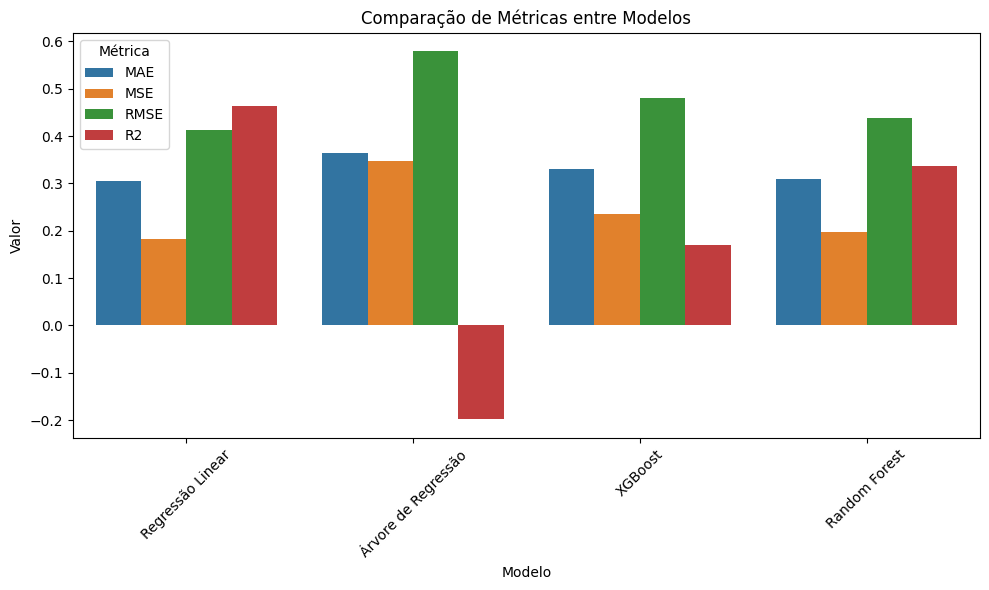

In [432]:
df_resultados_cluster = pd.DataFrame(resultados)

# Comparação dos modelos com gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_resultados_cluster.melt(id_vars="Modelo"), x="Modelo", y="value", hue="variable", ci=None)
plt.title("Comparação de Métricas entre Modelos")
plt.ylabel("Valor")
plt.xlabel("Modelo")
plt.legend(title="Métrica")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
